# Análise - O Oscar na Última Década

## Integrantes:

### João Victor Soares Silva | Mat.: 20210027300
### Marília Gabriela Toscano da Silva | Mat.: 20210067065
### Matheus Victor Alves Braga Maciel | Mat.:

# Introdução

///Texto da introdução e motivação

A motivação inicial foi observar quais as relações existentes entre as notas de avaliação de filmes no site estadunidense Rotten Tomatoes com os dados de indicados e ganhadores do Oscar, para saber se a opnião pública condizia com os resultados da academia.

## Objetivos

### Objetivos Gerais
* Encontrar quais variáveis (ano, gênero, duração, classificação indicativa, etc.) tinham maior relação com os resultados das premiações.
* Entender como as avaliações do público e da crítica afetam as chances de um filme ser ganhador da premiação

### Objetivos Específicos
* Descobrir quais características mais se repetiam entre os filmes vencedores da premiação
* Analisar quais os tipos de filme recebem melhores avaliações do público e da crítica
* Encontrar a melhor maneira de prever as chances de vitória de um filme com base em suas avaliações e suas propriedades

# Dados Usados

Bibliotecas utilizadas:

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

Dataframes utilizados:

* Dataset do Rotten Tomatoes : Contém informações técnicas sobre os filmes avaliados no site como: título, data original de lançamento, data de lançamento em sites de streaming, tempo de duração, gênero, diretor(es), elenco, roteirista(s), estúdio de cinema e classificação indicativa. Além disso, inclui uma breve sinopse da obra e um consenso geral dos comentários da crítica. Por fim, apresenta as porcentagens de avaliações positivas da audiência e dos críticos, quantidade de avaliações de cada um e algumas variáveis próprias do site; tais como, as classificações de "rotten" para filmes com menos de 60% de avaliações positivas da crítica e "fresh" para os com mais de 60%.

* Dataset do Oscar : Engloba dados de 1927 até 2020 referentes à cerimônia de premiação; como, ano e número do evento, título e ano de exibição dos filmes indicados, nomes dos artistas indicados, categorias de indicação e quais foram os vencedores.

Agora, vamos importar os dataframes:

In [86]:
#Dataframe dos indicados ao Oscar:

oscar = pd.read_csv('BigML_Dataset_5f50a62c2fb31c516d000176.csv')
oscar.head(1)

,year,movie,movie_id,certificate,duration,genre,rate,metascore,synopsis,votes,...,New_York_Film_Critics_Circle_nominated,New_York_Film_Critics_Circle_nominated_categories,Los_Angeles_Film_Critics_Association_won,Los_Angeles_Film_Critics_Association_won_categories,Los_Angeles_Film_Critics_Association_nominated,Los_Angeles_Film_Critics_Association_nominated_categories,release_date.year,release_date.month,release_date.day-of-month,release_date.day-of-week
0,2001,Kate & Leopold,tt0035423,PG-13,118,Comedy|Fantasy|Romance,6.4,44.0,An English Duke from 1876 is inadvertedly drag...,66660,...,0,NaN,0,NaN,0,NaN,2001.0,12.0,25.0,2.0


In [87]:
#Dataframe dos filmes no site Rotten Tomatoes:

rotten = pd.read_csv('rotten_tomatoes_movies.csv')
rotten.head(1)

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76


# Pré-Processamento

A seguir, iremos manipular os dataframes usados como base na pesquisa de forma que seja gerado um outro que contenha apenas as informações que serão relevantes para a pesquisa.
Começando pelo dataframe 'oscar':

1. O dataframe possui muitas colunas, para tornar o processamento dos dados mais ágil, iremos limpá-lo e deixar apenas as colunas que serão relevantes à pesquisa:

In [88]:
oscar = oscar[['year', 'movie', 'certificate', 'duration', 'genre', 'rate', 'votes', 'metascore', 'Oscar_Best_Picture_won', 'Oscar_Best_Director_won', 'Oscar_Best_Actor_won', 'Oscar_Best_Actress_won']]
oscar.head()

,year,movie,certificate,duration,genre,rate,votes,metascore,Oscar_Best_Picture_won,Oscar_Best_Director_won,Oscar_Best_Actor_won,Oscar_Best_Actress_won
0,2001,Kate & Leopold,PG-13,118,Comedy|Fantasy|Romance,6.4,66660,44.0,No,No,No,No
1,2000,Chicken Run,G,84,Animation|Adventure|Comedy,7.0,144475,88.0,No,No,No,No
2,2005,Fantastic Four,PG-13,106,Action|Adventure|Family,5.7,273203,40.0,No,No,No,No
3,2002,Frida,R,123,Biography|Drama|Romance,7.4,63852,61.0,No,No,No,No
4,2001,The Lord of the Rings: The Fellowship of the Ring,PG-13,178,Adventure|Drama|Fantasy,8.8,1286275,92.0,No,No,No,No


2. As linhas contendo valores nulos (NaN) foram descartadas, pois não é interessante algumas análises utilizarem uma amostra de dados maior que outras:

In [89]:
oscar = oscar.dropna()

3. Os filmes que concorreram à edição de 2000 foram descartados, visto que nosso corte temporal é este século:

In [90]:
oscar = oscar [(oscar.year > 2000)]
oscar.reset_index(inplace = True, drop = False)
oscar.head()

,index,year,movie,certificate,duration,genre,rate,votes,metascore,Oscar_Best_Picture_won,Oscar_Best_Director_won,Oscar_Best_Actor_won,Oscar_Best_Actress_won
0,0,2001,Kate & Leopold,PG-13,118,Comedy|Fantasy|Romance,6.4,66660,44.0,No,No,No,No
1,2,2005,Fantastic Four,PG-13,106,Action|Adventure|Family,5.7,273203,40.0,No,No,No,No
2,3,2002,Frida,R,123,Biography|Drama|Romance,7.4,63852,61.0,No,No,No,No
3,4,2001,The Lord of the Rings: The Fellowship of the Ring,PG-13,178,Adventure|Drama|Fantasy,8.8,1286275,92.0,No,No,No,No
4,6,2002,Resident Evil,R,100,Action|Horror|Sci-Fi,6.7,204545,33.0,No,No,No,No


Agora vamos manipular o dataframe 'rotten':

1. Aqui, vamos filtrar as colunas que utilizaremos:

In [91]:
rotten = rotten[['movie_title', 'tomatometer_status', 'tomatometer_rating', 'audience_status', 'audience_rating']]
rotten.head(1)

,movie_title,tomatometer_status,tomatometer_rating,audience_status,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,Rotten,49.0,Spilled,53.0


2. Por fim, vamos retirar as linhas que possuem valores vazios (NaN):

In [92]:
rotten = rotten.dropna()

Com isso feito, agora, vamos associar os filmes de um dataframe ao outro, através dos seus nomes:

In [93]:
#Renomeando a coluna de nomes para que fiquem idênticas:
rotten.rename(columns = {'movie_title':'movie'}, inplace = True)

#Juntando os dataframes:
df_final = pd.merge(oscar, rotten, how = 'inner', on = 'movie')
df_final.head(1)

,index,year,movie,certificate,duration,genre,rate,votes,metascore,Oscar_Best_Picture_won,Oscar_Best_Director_won,Oscar_Best_Actor_won,Oscar_Best_Actress_won,tomatometer_status,tomatometer_rating,audience_status,audience_rating
0,0,2001,Kate & Leopold,PG-13,118,Comedy|Fantasy|Romance,6.4,66660,44.0,No,No,No,No,Rotten,50.0,Upright,62.0


Para evitar distorção nos dados, vamos verificar quantos filmes foram perdidos nessa associação entre os dataframes:

In [94]:
# Verificando quantas linhas foram perdidas no merge:
print(f'Número de linhas do dataframe final: {df_final.shape[0]}')
print(f'Número de linhas perdidas no merge: {oscar.shape[0] - df_final.shape[0]}')
print(f'Percentual de perda de dados: {((oscar.shape[0] - df_final.shape[0]) * 100) / df_final.shape[0]:.2f}%')

Número de linhas do dataframe final: 1062
Número de linhas perdidas no merge: 27
Percentual de perda de dados: 2.54%


O número de filmes descartados pela associação não foi muito grande, contudo, as informações ficarão registradas para evitar dúvidas sobre distorções. Assim, acabamos nosso pré-processamento.

# Quais as características mais frequentes entre os filmes indicados à premiação?

Para responder essa pergunta, iremos analisar nosso dataframe final e encontrar quais os dados mais comuns nas seguintes colunas:
* 'certificate';
* 'duration';
* 'genre';
* 'rate';
* 'metascore';
* 'tomatometer_status';
* 'tomatometer_rating';
* 'audience_status';
* 'audience_rating'.

Classificação indicativa mais comum:

[Text(0.5, 0, 'Certificados'), Text(0, 0.5, 'Nº de ocorrências')]

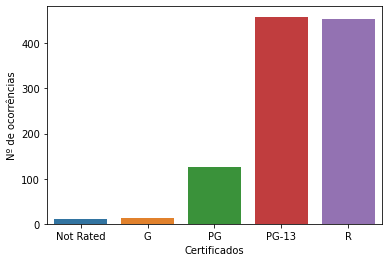

In [136]:
#Contando a frequência de cada classificação:
count_cert = df_final.groupby(['certificate']).size()

#Juntando classificações iguais, mas com termos distintos:
#Unrated e Not Rated:
count_cert['Not Rated'] += count_cert['Unrated']
del(count_cert['Unrated'])

#TV-MA e R:
count_cert['R'] += count_cert['TV-MA']
del(count_cert['TV-MA'])

#Organizando:
count_cert = count_cert.reindex(index = ['Not Rated', 'G', 'PG', 'PG-13', 'R'])

#Visualização:
count_cert.sort_values(ascending = False)

graph_cert = sns.barplot(x = count_cert.index, y = count_cert.values)
graph_cert.set(xlabel = 'Certificados', ylabel = 'Nº de ocorrências')

# Dentre os indicados, qual o perfil dos filmes que foram melhor aceitos pelo público e pela crítica?

# Qual o melhor parâmetro, entre os sites estudados, para determinar as chances de vitória de um filme nas categorias principais?

# Conclusão

///Resumir as respostas, destacar sua importância, apontar limitações, trabalhos futuros e melhorias.